In [109]:
import os
import deepchem as dc
from deepchem.utils.data_utils import load_from_disk, save_to_disk
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV
import multiprocessing
import time
import matplotlib.pyplot as plt

from rdkit import Chem
import deepchem as dc
import numpy as np
from sklearn.linear_model import LinearRegression
from deepchem.utils.data_utils import load_from_disk, save_to_disk
np.random.seed(0)

In [110]:
TRAIN = "../data/smiles_all_property.csv"
TARGET_COL = "intensity"
SMILES_COL = "smiles"
PROPERTY = TARGET_COL


if TARGET_COL == "Decomposition Energy":
    PROPERTY = "Decomposition_Energy"
elif TARGET_COL == "HOMO/LUMO gap":
    PROPERTY = "HOMOLUMO_gap"

MODEL_DIR = "../model/" + PROPERTY
LOG_DIR = "../log/" + PROPERTY

DATA_DIR = "../data/" + PROPERTY

DATA_EXIST = os.path.exists(DATA_DIR + "/tasks.json")

In [111]:
# モデルのロード
loaded_model = load_from_disk(MODEL_DIR + "/model.joblib")

Exception ignored in: <function Model.__del__ at 0x7f987211b9d0>
Traceback (most recent call last):
  File "/home/ishii/mambaforge/envs/lightgbm/lib/python3.9/site-packages/deepchem/models/models.py", line 60, in __del__
    shutil.rmtree(self.model_dir)
  File "/home/ishii/mambaforge/envs/lightgbm/lib/python3.9/shutil.py", line 724, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/home/ishii/mambaforge/envs/lightgbm/lib/python3.9/shutil.py", line 722, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpylpc4kvt'


In [112]:
featurizer = dc.feat.RDKitDescriptors()

In [113]:
# 学習データの読み込み
loader = dc.data.CSVLoader(tasks=[TARGET_COL],
                            feature_field=SMILES_COL,
                            featurizer=featurizer)

In [114]:
if DATA_EXIST == True:
    dataset = dc.data.DiskDataset(DATA_DIR)
else:
    dataset = loader.create_dataset(TRAIN, data_dir=DATA_DIR)

In [115]:
splitter = dc.splits.IndexSplitter()

train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2)

transformers = [dc.trans.NormalizationTransformer(transform_y=True,dataset=train_dataset)]

In [116]:
train_dataset.y

array([[-1.66554424],
       [-1.46217965],
       [-3.69875291],
       ...,
       [-0.81815613],
       [-1.8664579 ],
       [-1.87942278]])

In [117]:
np.mean(train_dataset.y)

-1.825198187884293

In [119]:
np.var(train_dataset.y)

1.7923622490687516

In [118]:
np.std(train_dataset.y)

1.33879133888323

In [96]:
for transformer in transformers:
    train_dataset = transformer.transform(train_dataset)
    valid_dataset = transformer.transform(valid_dataset)
    #test_dataset = transformer.transform(test_dataset)

In [97]:
smiles = test_dataset.ids[0]
smiles

'N#Cc1cccnc1N1CCN(C(=O)COCC(=O)O)CC1'

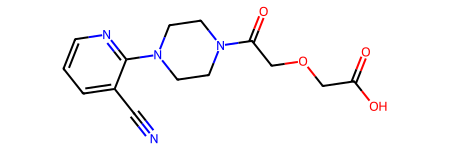

In [98]:
mol = Chem.MolFromSmiles(smiles)
mol

In [99]:
Chem.MolToSmiles(mol)

'N#Cc1cccnc1N1CCN(C(=O)COCC(=O)O)CC1'

In [100]:
features = featurizer.featurize(smiles)
features

array([[ 1.18673844e+01,  1.18673844e+01,  2.33863405e-01,
        -1.10018131e+00,  7.95668369e-01,  3.04306000e+02,
         2.88178000e+02,  3.04117155e+02,  1.16000000e+02,
         0.00000000e+00,  3.29164092e-01, -4.79533450e-01,
         4.79533450e-01,  3.29164092e-01,  1.31818182e+00,
         2.04545455e+00,  2.68181818e+00,  1.65038374e+01,
         1.02036812e+01,  2.22874422e+00, -2.35160626e+00,
         2.17481095e+00, -2.49825784e+00,  5.77962814e+00,
        -1.45471670e-01,  2.54224662e+00,  1.86388699e+00,
         5.90750788e+02,  1.59493830e+01,  1.19355043e+01,
         1.19355043e+01,  1.06133922e+01,  6.78919108e+00,
         6.78919108e+00,  4.74074542e+00,  4.74074542e+00,
         3.29011795e+00,  3.29011795e+00,  2.22082467e+00,
         2.22082467e+00, -2.66000000e+00,  2.54224662e+00,
         1.57236452e+01,  7.37735185e+00,  3.92602098e+00,
         1.27072769e+02,  1.96432098e+01,  2.51008480e+01,
         0.00000000e+00,  5.90717973e+00,  0.00000000e+0

In [101]:
data = dc.data.DiskDataset.from_numpy(features)
data

<DiskDataset X.shape: (1, 209), y.shape: (1, 1), w.shape: (1, 1), ids: [0], task_names: [0]>

In [102]:
test_dataset

<DiskDataset X.shape: (17526, 209), y.shape: (17526, 1), w.shape: (17526, 1), task_names: ['intensity']>

In [103]:
loaded_model.predict(data, transformers=transformers)[0]

-1.6082208533769489

In [106]:
train_dataset.y

array([[ 0.1192523 ],
       [ 0.27115394],
       [-1.39943744],
       ...,
       [ 0.7522024 ],
       [-0.03081863],
       [-0.04050265]])

In [107]:
np.mean(train_dataset.y)

-1.558907192824246e-15

In [108]:
np.std(train_dataset.y)

1.0000000000000042